In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from node import Node
from graph import DiGraph
import numpy as np
import matplotlib.pyplot as plt

In [22]:
from vco import VCO
from amplifier import Amplifier
from voltage import Voltage   
from mixer import Mixer
from rack import Rack
from adsr import ADSR
from lpfilter import Filter

In [59]:
rack = Rack()
fs = 48000 # Hz

voltage_a = Voltage(value = 1)
voltage_d = Voltage(value = 0.5)
voltage_s = Voltage(value = 0.5)
voltage_r = Voltage(value = 3)
voltage_trigger = Voltage(value = 0)
voltage_frequency_filter = Voltage(value = 0.2)
voltage_resonance_filter = Voltage(value = 0.0)

adsr = ADSR(
    trigger = voltage_trigger,
    attack = voltage_a, 
    delay = voltage_d, 
    sustain = voltage_s, 
    release = voltage_r)

filter_offset = Voltage(value = 0.1)
adsr_filter = Mixer(inputs = [filter_offset, adsr])

voltage_f = Voltage(value = 1000)
vco_0 = VCO(frequency = voltage_f, fs = fs, shape = 'square')
filter_0 = Filter(
    value = vco_0, 
    frequency = adsr_filter, 
    resonance = voltage_resonance_filter)
amp_adsr = Amplifier(value = filter_0, gain = adsr)


modules = [voltage_a, 
           voltage_d, 
           voltage_s, 
           voltage_r, 
           voltage_trigger, 
           voltage_frequency_filter, 
           voltage_resonance_filter, 
           adsr, 
           filter_offset,
           adsr_filter,
           voltage_f, 
           vco_0, 
           filter_0,
           amp_adsr]

for module in modules:
    rack.add_object(module)

all right
Status.IDLE
1
0
going attack
going delay
going sustain
all right
Status.SUSTAIN
0
1
going release
going idle


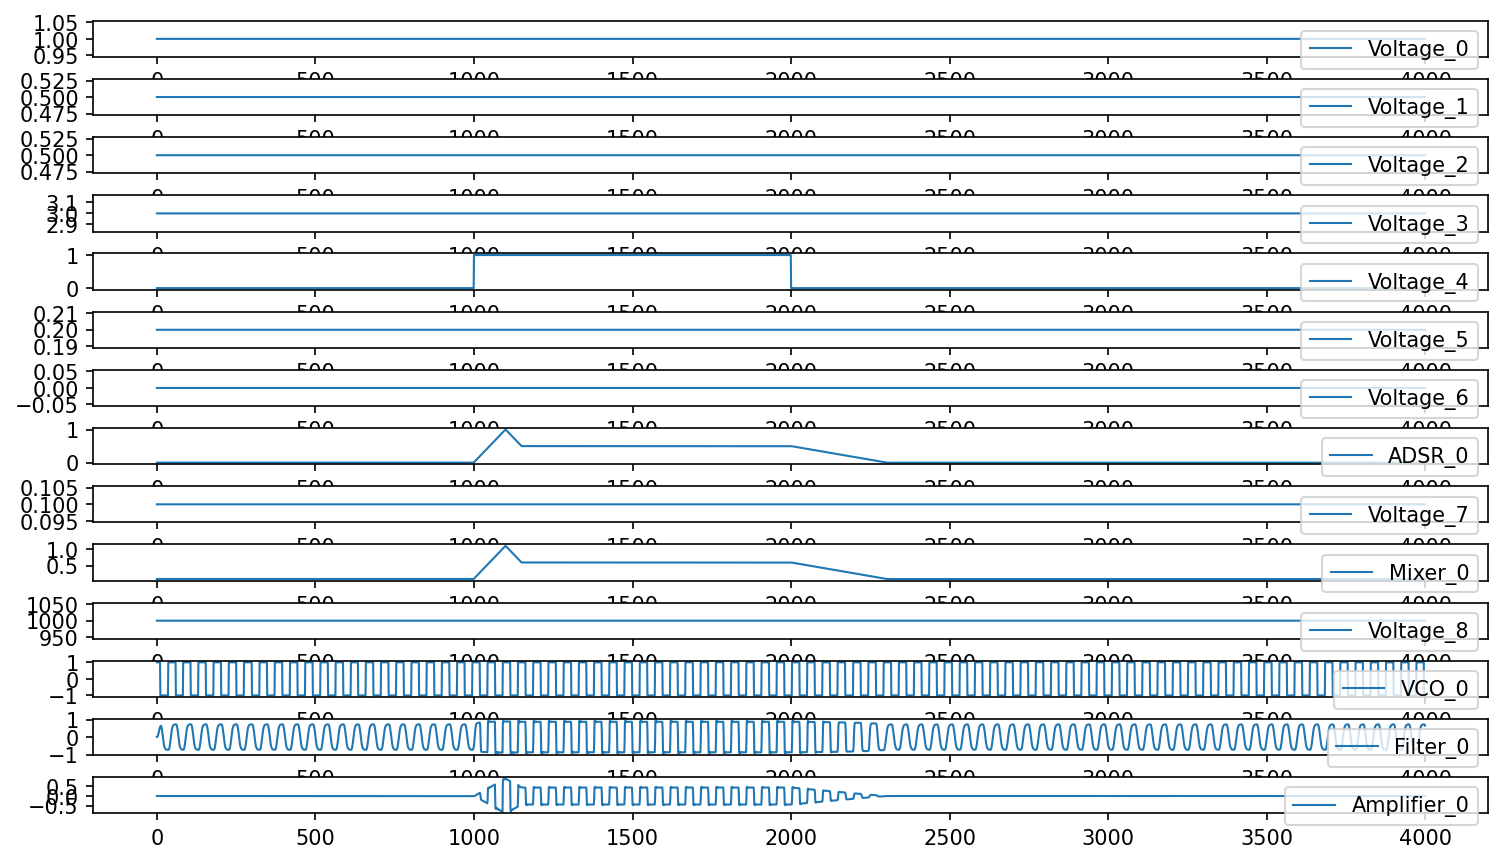

In [60]:
n_ite = 4000
probe = {k:np.zeros(n_ite) for k in rack.objects.keys()}

for iteration in range(n_ite):
    if iteration == 0:
        voltage_trigger.outputs[0] = 0
    if iteration == 1000:
        voltage_trigger.outputs[0] = 1
    if iteration == 2000:
        voltage_trigger.outputs[0] = 0
    rack.step()
    for object_name in rack.objects.keys():
        probe[object_name][iteration] = rack.objects[object_name].outputs[0]
        
plt.figure(figsize = (12, 7), dpi = 150)
for i, object_name in enumerate(rack.objects.keys()):
    plt.subplot(len(rack.objects.keys()), 1, i+1)
    plt.plot(probe[object_name], label = object_name, linewidth = 1)
    plt.legend(loc = 'upper right')
plt.subplots_adjust(hspace = 0.6)

In [ ]:
p = pyaudio.PyAudio()
stream = p.open(format=p.get_format_from_width(2),
            channels=1,
            rate=fs,
            output=True)

buffer_size, n_buffers = 512, 1000
history_buffer = np.zeros((n_buffers, buffer_size))

output_port = vco # Which module output is streamed
for buffer_id in range(n_buffers):
    buffer_int = np.zeros(buffer_size, dtype=np.int16)
    buffer_float = np.zeros(buffer_size, dtype=np.float32)
    for sample_id in range(buffer_size):
        my_rack.update()
        sample = probe['Amplifier_0'] * 0.5 # Volume
        sample *= 2**16/2 # Int range normalization
        buffer_int[sample_id] = sample
    history_buffer[buffer_id, :] = buffer_int
    stream.write(buffer_int.tobytes()) 
    
stream.close()